In [1]:
#!pip install torch
#!pip install opencv-python
#!pip install bottleneck --upgrade
#!pip install tensorflow --upgrade

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2


In [3]:
# Define folder paths
folder_path = r"C:\Users\padal\OneDrive\Desktop\my projects\Brain Tumour\archive\Brain_Tumor_Dataset"
negative_folder = 'Negative'
positive_folder = 'Positive'

# Load image filenames
negative_images = os.listdir(os.path.join(folder_path, negative_folder))
positive_images = os.listdir(os.path.join(folder_path, positive_folder))

# Define lists to store images and labels
dataset = []
labels = []

# Load 'Negative' images
for image_name in negative_images:
    image_path = os.path.join(folder_path, negative_folder, image_name)
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    dataset.append(image)
    labels.append(0)

# Load 'Positive' images
for image_name in positive_images:
    image_path = os.path.join(folder_path, positive_folder, image_name)
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    dataset.append(image)
    labels.append(1)

# Convert to NumPy arrays
X, y = np.array(dataset), np.array(labels)

In [4]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.05, random_state=True)

# Data augmentation
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.1
)

In [5]:
# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the pre-trained weights

In [6]:
# Global average pooling layer
global_average_layer = GlobalAveragePooling2D()

In [7]:
# Prediction layer
prediction_layer = Dense(1, activation='sigmoid')

In [8]:
# Build the model
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [9]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

In [11]:
# Train the model with early stopping
history = model.fit(datagen_train.flow(X_train, Y_train, batch_size=32),
                    epochs=15,
                    validation_data=(X_test, Y_test),
                    callbacks=[early_stopping])

Epoch 1/15


157/157 [==============================] - 98s 581ms/step - loss: 0.3309 - accuracy: 0.8587 - val_loss: 0.2430 - val_accuracy: 0.9205
Epoch 2/15
157/157 [==============================] - 90s 573ms/step - loss: 0.1830 - accuracy: 0.9344 - val_loss: 0.2100 - val_accuracy: 0.9242
Epoch 3/15
157/157 [==============================] - 92s 586ms/step - loss: 0.1587 - accuracy: 0.9456 - val_loss: 0.2048 - val_accuracy: 0.9280
Epoch 4/15
157/157 [==============================] - 93s 588ms/step - loss: 0.1440 - accuracy: 0.9468 - val_loss: 0.1725 - val_accuracy: 0.9242
Epoch 5/15
157/157 [==============================] - 94s 597ms/step - loss: 0.1390 - accuracy: 0.9498 - val_loss: 0.2068 - val_accuracy: 0.9356
Epoch 6/15
157/157 [==============================] - 93s 593ms/step - loss: 0.1322 - accuracy: 0.9518 - val_loss: 0.1931 - val_accuracy: 0.9356
Epoch 7/15
157/157 [==============================] - 93s 590ms/step - loss: 0.1269 - accuracy: 0.9556 - val_loss: 0.1807 - val_

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


9/9 [==============================] - 2s 257ms/step - loss: 0.1388 - accuracy: 0.9508
Test Loss: 0.13882844150066376
Test Accuracy: 0.9507575631141663


In [13]:
model.save("Brain_Tumor_Detection_Mobilev2Net.keras")


In [14]:
# Make predictions
predictions = model.predict(X_test)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Calculate precision, recall, and F1 score
precision = precision_score(Y_test, predicted_labels)
recall = recall_score(Y_test, predicted_labels)
f1 = f1_score(Y_test, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

9/9 [==============================] - 4s 249ms/step
Precision: 0.9753086419753086
Recall: 0.9461077844311377
F1 Score: 0.9604863221884499


In [15]:
# Get the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


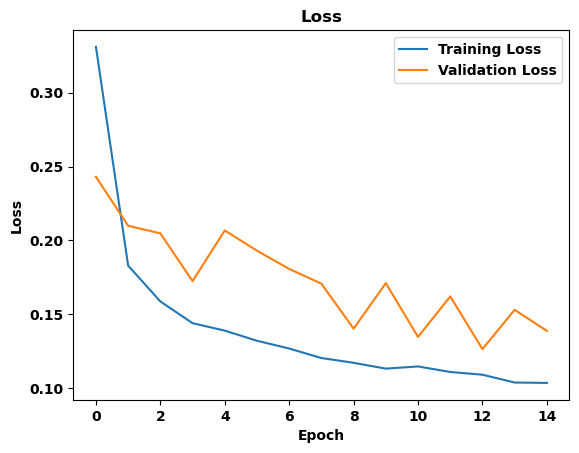

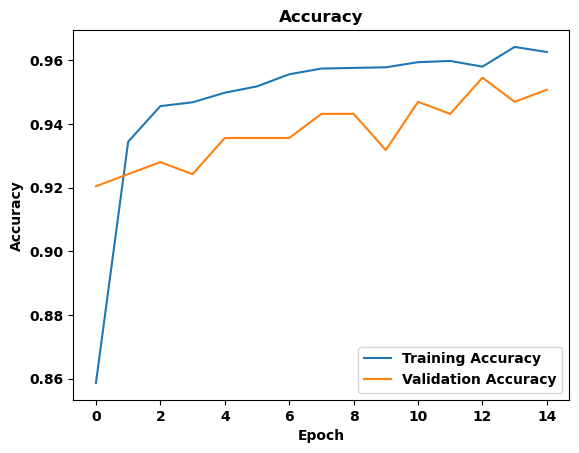

In [16]:
# Plot metrics
def plot_metrics(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Loss plot
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy plot
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history)

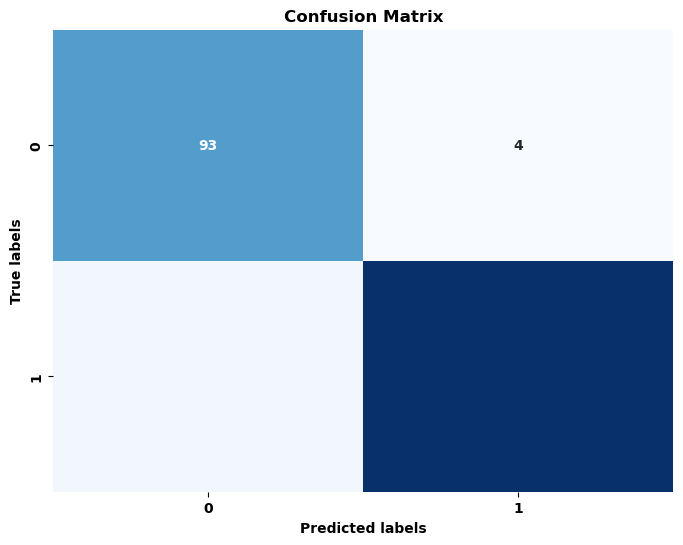

In [17]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(Y_test, predicted_labels)


In [18]:
# Additional evaluation metrics
# Make predictions on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate precision, recall, F1 score, and support
report = classification_report(Y_test, y_pred_binary)

# Calculate confusion matrix
cm = confusion_matrix(Y_test, y_pred_binary)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(Y_test, y_pred)

# Display classification report, confusion matrix, and ROC-AUC score
print("Classification Report:")
print(report)
print("\nConfusion Matrix:")
print(cm)
print("\nROC-AUC Score:", roc_auc)


9/9 [==============================] - 2s 257ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        97
           1       0.98      0.95      0.96       167

    accuracy                           0.95       264
   macro avg       0.94      0.95      0.95       264
weighted avg       0.95      0.95      0.95       264


Confusion Matrix:
[[ 93   4]
 [  9 158]]

ROC-AUC Score: 0.9881474165071918
